<a href="https://colab.research.google.com/github/G-Conard/ds595-final-project/blob/main/DS_595_Team_3_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Website https://siglosrrd.org/estacion-de-medicion-ambiental-mariato/

In [ ]:
import numpy as np
import matplotlib.pylab as py
import random
import torch
import torch.optim as optim
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import concurrent.futures
from tabulate import tabulate
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import FastICA
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import FastICA
from numpy import savetxt
from numpy import loadtxt
import datetime
import torch
import torch.optim as optim
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(50) # this makes results reproducable

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#this is a check to see if a GPU machine that pytorch can use for training
if torch.cuda.is_available():
    print('CUDA available')
    print(torch.cuda.get_device_name(0))
else:
    print('CUDA *not* available')

CUDA *not* available


In [3]:
#temporary use of prior data set from case study 1 to test code until real dataset imported

import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/G-Conard/ds595-final-project/main/weather_stations_data.csv')

raw_data = data #use this raw_data var to act as the raw dataset once imported please

print(raw_data.head())

        id  station_id  tempc  humidity  dewptc  windchillc  winddir  \
0  22954.0         3.0  35.11      56.0   25.00       35.11    295.0   
1  22956.0         3.0  35.50      57.0   25.72       35.50    217.0   
2  22958.0         3.0  35.50      56.0   25.39       35.50    236.0   
3  22960.0         3.0  34.61      56.0   24.61       34.61    276.0   
4  22962.0         3.0  33.78      57.0   24.11       33.78    242.0   

   windspeedkmh  windgustkmh  rainmm  ...   UV  indoortempc  indoorhumidity  \
0          5.76         9.37     0.0  ...  0.0        36.39            51.0   
1          3.60         7.19     0.0  ...  0.0        36.28            53.0   
2          5.76         9.37     0.0  ...  0.0        36.22            54.0   
3          2.88         7.19     0.0  ...  0.0        36.11            51.0   
4          1.80         7.19     0.0  ...  0.0        35.78            52.0   

   absbarohpa  barohpa  rad_tempc  rad_hum  aqpm25  heat_index       timestamp  
0     1010.

In [ ]:
raw_data = raw_data.drop(['id', 'station_id', 'timestamp'], axis=1)
print(raw_data.head())

   tempc  humidity  dewptc  windchillc  winddir  windspeedkmh  windgustkmh  \
0  35.11      56.0   25.00       35.11    295.0          5.76         9.37   
1  35.50      57.0   25.72       35.50    217.0          3.60         7.19   
2  35.50      56.0   25.39       35.50    236.0          5.76         9.37   
3  34.61      56.0   24.61       34.61    276.0          2.88         7.19   
4  33.78      57.0   24.11       33.78    242.0          1.80         7.19   

   rainmm  dailyrainmm  weeklyrainmm  ...  solarradiation   UV  indoortempc  \
0     0.0         0.79          0.79  ...          425.63  0.0        36.39   
1     0.0         0.79          0.79  ...          403.22  0.0        36.28   
2     0.0         0.79          0.79  ...          389.98  0.0        36.22   
3     0.0         0.79          0.79  ...          138.56  0.0        36.11   
4     0.0         0.79          0.79  ...          166.95  0.0        35.78   

   indoorhumidity  absbarohpa  barohpa  rad_tempc  rad_h

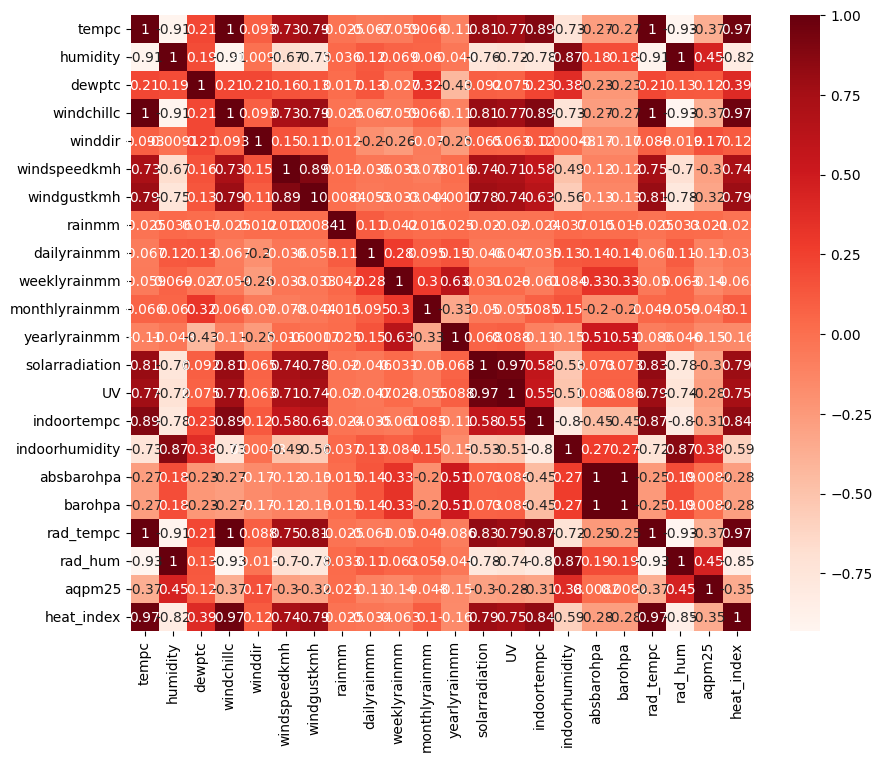

In [ ]:
#Analize the individual predictors and their correlations with the target variable

#the Feature to predict in the dataset, and the Column predictors in the datasets
Feature = ["heat_index"]
Labels = ['tempc', 'humidity', 'dewptc', 'windchillc', 'winddir', 'windspeedkmh', 'windgustkmh', 'rainmm', 'dailyrainmm', 'weeklyrainmm', 'monthlyrainmm', 'yearlyrainmm', 'solarradiation', 'UV', 'indoortempc', 'indoorhumidity', 'absbarohpa', 'barohpa', 'rad_tempc', 'rad_hum', 'aqpm25']

plt.figure(figsize=(10,8))
cor = raw_data.corr()
sns.heatmap(cor, annot=True,cmap=plt.cm.Reds)
plt.show()

sns.pairplot(raw_data)

plt.figure(figsize=(10,8))
Temp_x=raw_data[Labels]
Temp_y=raw_data[Feature]
selectKbest = SelectKBest(score_func=f_regression, k='all')
Temp_fit = selectKbest.fit(Temp_x,Temp_y)
plt.bar(x=Temp_x.columns,height=Temp_fit.scores_)

In [ ]:
#methods testing function

def RegressionModelsTester(dataset, feature, method, CVFolds=4):

  Labels = dataset[2]

  CAList = [("None", None, 0)] \
         + [("PCA", PCA(n_components=pc), pc) for pc in range(1, len(Labels)+1)] \
         + [("SparsePCA", SparsePCA(n_components=pc, random_state=0), pc) for pc in range(1, len(Labels)+1)] \
         + [("MiniBatchSparsePCA", MiniBatchSparsePCA(n_components=pc, random_state=0), pc) for pc in range(1, len(Labels)+1)] \
         + [("FactorAnalysis", FactorAnalysis(n_components=pc, random_state=0), pc) for pc in range(1, len(Labels)+1)] \
         + [("IncrementalPCA", IncrementalPCA(n_components=pc, batch_size=200), pc) for pc in range(1, len(Labels)+1)] \
         + [("FastICA", FastICA(n_components=pc, random_state=0), pc) for pc in range(1, len(Labels)+1)] \

  result = []

  for ca in CAList:

    for split in range(1, 10):

      X = dataset[0][Labels]
      y = dataset[0][feature]

      if not ca[1] is None:
        #component analysis
        sc = StandardScaler()
        CA = ca[1]
        X = sc.fit_transform(X)
        X = CA.fit_transform(X)

      # split training data and testing
      Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=(split/10),shuffle=True, random_state=1)

      model = method[0]
      model.fit(Xtrain,ytrain)
      ypred = model.predict(Xtest)

      MAE=mean_absolute_error(ypred,ytest)
      MSE=mean_squared_error(ypred,ytest)
      RMSE=np.sqrt(mean_squared_error(ypred,ytest))
      R2=r2_score(ypred,ytest)

      MAPE = mean_absolute_percentage_error(ytest, ypred)

      #cross vaidation
      crossValLists = cross_val_score(model, X, y, cv=CVFolds)
      avg_cross_val_score = (sum(crossValLists) / len(crossValLists))

      result.append([dataset[1], method[1], (split/10), ca[0], ca[2], CVFolds, avg_cross_val_score, R2, MSE, RMSE, MAE, MAPE])

  return result


In [ ]:
#perform feature engineering here to create multiple trial data sets then add the data set and label into FeatureEngineeredDatasetsList below

In [ ]:
#This block is to take all the datasets to run through the Regressor Function above to evaluate all possible aspects for all models with each dataset and record and output the results

FeatureEngineeredDatasetsList = [(raw_data, "Raw Dataset", Labels)] #(dataset, string label, dataset column labels)



methodlist = [(linear_model.LinearRegression(), "Linear"),
              (KNeighborsRegressor(n_neighbors=20), "KNeighborsRegressor"),
              (linear_model.Ridge(), "Ridge"),
              (linear_model.Lasso(), "Lasso"),
              (linear_model.BayesianRidge(), "BayesianRidge"),
              (DecisionTreeRegressor(), "DecisionTreeRegressor"),
              (RandomForestRegressor(), "RandomForestRegressor")]


cv_folds = 4 #for cross vallidation

Final_Regression_Analysis_Results = []

# Create a thread pool to test all the datasets using all models
with concurrent.futures.ThreadPoolExecutor(max_workers=len(FeatureEngineeredDatasetsList)*len(methodlist)) as pool:
    # Submit individual function calls with their arguments to the thread pool
    evaluators = [pool.submit(RegressionModelsTester, dataset, Feature, method, cv_folds) for dataset in FeatureEngineeredDatasetsList for method in methodlist]

    # Wait for all tasks to complete
    for evaluator in concurrent.futures.as_completed(evaluators):
        # Retrieve the result of each task (this will block until the task completes)
        Final_Regression_Analysis_Results.extend(evaluator.result())

#Print the Final Analysis Results Fully
print(tabulate(Final_Regression_Analysis_Results, headers=["Dataset", "Model", "Train/Test Split", "CA Method", "Primary Components", "CV Folds", "Avg. Cross Val Score", "R^2", "MSE", "RMSE", "MAE", "MAPE"],tablefmt="grid"))


In [ ]:

#analize the results for the best performance
best_avg_cv_score = 0
best_avg_cv_score_idx = 0

best_R2 = 0
best_R2_idx = 0

best_MSE = 0
best_MSE_idx = 0

best_RMSE = 0
best_RMSE_idx = 0

best_MAE = 0
best_MAE_idx = 0

best_MAPE = 0
best_MAPE_idx = 0

avg_cv_score = 6
r2 = 7
mse = 8
rmse = 9
mae = 10
mape = 11


for idx in range(len(Final_Regression_Analysis_Results)):

  result = Final_Regression_Analysis_Results[idx]

  #CV Score
  if result[avg_cv_score] > best_avg_cv_score:
    best_avg_cv_score = result[avg_cv_score]
    best_avg_cv_score_idx = idx

  #R^2
  if result[r2] > best_R2:
    best_R2 = result[r2]
    best_R2_idx = idx

  #MSE
  if result[mse] > best_MSE:
    best_MSE = result[mse]
    best_MSE_idx = idx

  #RMSE
  if result[rmse] > best_RMSE:
    best_RMSE = result[rmse]
    best_RMSE_idx = idx

  #MAE
  if result[mae] > best_MAE:
    best_MAE = result[mae]
    best_MAE_idx = idx

  #MAPE
  if result[mape] > best_MAPE and result[mape] >= 0:
    best_MAPE = result[mape]
    best_MAPE_idx = idx


Best_Regression_Results = [["Best Avg. Cross Val Score"] + Final_Regression_Analysis_Results[best_avg_cv_score_idx],
                           ["Best R^2"] + Final_Regression_Analysis_Results[best_R2_idx],
                           ["Best MSE"] + Final_Regression_Analysis_Results[best_MSE_idx],
                           ["Best RMSE"] + Final_Regression_Analysis_Results[best_RMSE_idx],
                           ["Best MAE"] + Final_Regression_Analysis_Results[best_MAE_idx],
                           ["Best MAPE"] + Final_Regression_Analysis_Results[best_MAPE_idx]]

print(tabulate(Best_Regression_Results, headers=["Best Metric", "Dataset", "Model", "Train/Test Split", "CA Method", "Primary Components", "CV Folds", "Avg. Cross Val Score", "R^2", "MSE", "RMSE", "MAE", "MAPE"],tablefmt="grid"))


In [ ]:
def train(training_inputs, training_outputs, network, epochs, learning_rate, batch_size, loss_function, print_interval):

  network.train()

  train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(training_inputs).float(),
                                                 torch.from_numpy(training_outputs).float())

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True)

  optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=1e-5)
  track_losses = np.zeros(epochs)

  start = time.time()

  for epoch in range(1, epochs+1):

      for batch_idx, (X, y) in enumerate(train_loader):

          data = X

          data = data.to(DEVICE)

          output = network.forward(data)

          loss = loss_function(output, y.view([-1, 1]).to(DEVICE))

          optimizer.zero_grad()

          loss.backward()

          optimizer.step()

      training_loss = loss.item()**.5
      track_losses[epoch-1] = training_loss
      if epoch % print_interval == 0:
          print('epoch: %4d training loss:%10.3e time:%7.1f'%(epoch, training_loss, time.time()-start))

  return network, track_losses


def model_eva(XTrain,XTest,yTrain,yTest,model):

  model.eval()

  XTrain_th = torch.from_numpy(XTrain).float().to(DEVICE)
  XTest_th = torch.from_numpy(XTest).float().to(DEVICE)
  #yTrain_th=torch.Tensor(yTrain).cuda()
  #yTest_th=torch.Tensor(yTest).cuda()

  yTrain_pred = model.forward(XTrain_th)

  yTrain_pred_np = yTrain_pred.cpu().detach().numpy().reshape(-1)

  yTest_pred = model.forward(XTest_th)
  yTest_pred_np = yTest_pred.cpu().detach().numpy().reshape(-1)

  MAE_train=mean_absolute_error(yTrain_pred_np,yTrain)
  MSE_train=mean_squared_error(yTrain_pred_np,yTrain)
  RMSE_train=np.sqrt(mean_squared_error(yTrain_pred_np,yTrain))
  R2_train=r2_score(yTrain_pred_np,yTrain)

  MAE_test=mean_absolute_error(yTest_pred_np,yTest)
  MSE_test=mean_squared_error(yTest_pred_np,yTest)
  RMSE_test=np.sqrt(mean_squared_error(yTest_pred_np,yTest))
  R2_test=r2_score(yTest_pred_np,yTest)

  return MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test

In [ ]:
#NN Models go gere to try then add the model instantiation to the NN_Methods_List below

#test network 1
class testnetworks(nn.Module):
    def __init__(self, modelnum):
        super().__init__()
        self.modelnum = modelnum
        self.structureslist = [nn.Sequential(
                                    nn.Linear(7,5),
                                    nn.Sigmoid(),
                                    nn.Linear(5,4),
                                    nn.LeakyReLU(),
                                    nn.Linear(4,3),
                                    nn.ReLU(),
                                    nn.Linear(3,1)
                                    ),
                                nn.Sequential(
                                    nn.Linear(7,5),
                                    nn.Sigmoid(),
                                    nn.Linear(5,4),
                                    nn.Sigmoid(),
                                    nn.Linear(4,3),
                                    nn.Sigmoid(),
                                    nn.Linear(3,1)
                                    )
                               ]

        self.structure = self.structurelist[self.modelnum]

    def getNumModels(self):
      return len(self.structureslist)

    def forward(self, x):
        x = self.structure(x)
        return x

In [ ]:
def NN_Results_Tester(dataset, feature, nnmethod, tests, criterion, print_interval):

  X = dataset[0][dataset[2]].values
  y = dataset[0][feature].values

  for test in tests:

    batch_size_test = test[0]
    num_epochs_test = test[1]
    learning_rate_test = test[2]

    results = []

    for split in range(1, 10):

      Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=(split/10),shuffle=True, random_state=1)

      NNmodel = nnmethod[0].to(DEVICE)

      network, losses = train(Xtrain, ytrain, NNmodel, num_epochs_test, learning_rate_test, batch_size_test, criterion, print_interval)

      MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test = model_eva(Xtrain,Xtest,ytrain,ytest,network)
      results.append([dataset[1], nnmethod[1], (split/10), num_epochs_test, learning_rate_test, batch_size_test, MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test])

  return results

In [ ]:
NN_Methods_List = [(testnetworks(i), "NN Model " + str(i)) for i in range(testnetworks(0).getNumModels())]

tests = [(50, 500, 1e-2), #batch_size, num_epochs, learning_rate
         (100, 1000, 1e-3),
         (200, 2000, 1e-4)]

criterion = nn.MSELoss()

print_interval = 500


Final_NN_Analysis_Results = []

# Create a thread pool to test all the datasets using all models
with concurrent.futures.ThreadPoolExecutor(max_workers=len(FeatureEngineeredDatasetsList)*len(NN_Methods_List)) as pool:
    # Submit individual function calls with their arguments to the thread pool
    evaluators = [pool.submit(NN_Results_Tester, dataset, Feature, nn_method, tests, criterion, print_interval) for dataset in FeatureEngineeredDatasetsList for nn_method in NN_Methods_List]

    # Wait for all tasks to complete
    for evaluator in concurrent.futures.as_completed(evaluators):
        # Retrieve the result of each task (this will block until the task completes)
        Final_NN_Analysis_Results.extend(evaluator.result())

#Print the Final Analysis Results Fully
print(tabulate(Final_NN_Analysis_Results, headers=["Dataset", "Model", "Train/Test Split", "Num Epochs", "Learning Rate", "Batch Size", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))


In [ ]:

#analize the results for the best performance
best_Training_MAE = 0
best_Training_MAE_idx = 0

best_Training_MSE = 0
best_Training_MSE_idx = 0

best_Training_RMSE = 0
best_Training_RMSE_idx = 0

best_Training_R2 = 0
best_Training_R2_idx = 0

best_Test_MAE = 0
best_Test_MAE_idx = 0

best_Test_MSE = 0
best_Test_MSE_idx = 0

best_Test_RMSE = 0
best_Test_RMSE_idx = 0

best_Test_R2 = 0
best_Test_R2_idx = 0

train_mae = 3
train_mse = 4
train_rmse = 5
train_r2 = 6
test_mae = 7
test_mse = 8
test_rmse = 9
test_r2 = 10

for idx in range(len(Final_NN_Analysis_Results)):

  result = Final_NN_Analysis_Results[idx]

  #Training MAE
  if result[train_mae] > best_Training_MAE:
    best_Training_MAE = result[train_mae]
    best_Training_MAE_idx = idx

  #Training MSE
  if result[train_mse] > best_Training_MSE:
    best_Training_MSE = result[train_mse]
    best_Training_MSE_idx = idx

  #Training RMSE
  if result[train_rmse] > best_Training_RMSE:
    best_Training_RMSE = result[train_rmse]
    best_Training_RMSE_idx = idx

  #Training R2
  if result[train_r2] > best_Training_R2:
    best_Training_R2 = result[train_r2]
    best_Training_R2_idx = idx

  #Testing MAE
  if result[test_mae] > best_Test_MAE:
    best_Test_MAE = result[test_mae]
    best_Test_MAE_idx = idx

  #Testing MSE
  if result[test_mse] > best_Test_MSE:
    best_Test_MSE = result[test_mse]
    best_Test_MSE_idx = idx

  #Testing RMSE
  if result[test_rmse] > best_Test_RMSE:
    best_Test_RMSE = result[test_rmse]
    best_Test_RMSE_idx = idx

  #Testing R2
  if result[test_r2] > best_Test_R2:
    best_Test_R2 = result[test_r2]
    best_Test_R2_idx = idx


Best_NN_Results = [["Best Training MAE"] + Final_NN_Analysis_Results[best_Training_MAE_idx],
                   ["Best Training MSE"] + Final_NN_Analysis_Results[best_Training_MSE_idx],
                   ["Best Training RMSE"] + Final_NN_Analysis_Results[best_Training_RMSE_idx],
                   ["Best Training R2"] + Final_NN_Analysis_Results[best_Training_R2_idx],
                   ["Best Testing MAE"] + Final_NN_Analysis_Results[best_Test_MAE_idx],
                   ["Best Testing MSE"] + Final_NN_Analysis_Results[best_Test_MSE_idx],
                   ["Best Testing RMSE"] + Final_NN_Analysis_Results[best_Test_RMSE_idx],
                   ["Best Testing R2"] + Final_NN_Analysis_Results[best_Test_R2_idx]]

print(tabulate(Best_NN_Results, headers=["Best Metric", "Dataset", "Model", "Train/Test Split", "Num Epochs", "Learning Rate", "Batch Size", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))


In [ ]:
#comparison of the best Regression models and the best NN Models
print(tabulate(Best_Regression_Results, headers=["Best Metric", "Dataset", "Model", "Train/Test Split", "CA Method", "Primary Components", "CV Folds", "Avg. Cross Val Score", "R^2", "MSE", "RMSE", "MAE", "MAPE"],tablefmt="grid"))
print(tabulate(Best_NN_Results, headers=["Best Metric", "Dataset", "Model", "Train/Test Split", "Num Epochs", "Learning Rate", "Batch Size", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

In [ ]:
#import a fresh new daily set of data to then use as a heirarical means to cross validate the models we like best here